In [ ]:
!pip install ultralytics --quiet


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import torch
from ultralytics import YOLO


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
VIDEO_PATH = "/content/drive/MyDrive/CPS843 Project/DATA1.mp4"

print("Video exists:", os.path.exists(VIDEO_PATH))


Video exists: True


In [ ]:
# YOLOv5n via torch hub
model_5n = torch.hub.load("ultralytics/yolov5", "yolov5n", pretrained=True)

# YOLOv8n via ultralytics
model_8n = YOLO("yolov8n.pt")

print("Models loaded successfully.")


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-12-14 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs
Adding AutoShape... 


Models loaded successfully.


In [ ]:
FRAME_SKIP = 1

VEHICLE_CLASSES = ["car", "truck", "bus", "motorbike"]

def run_model(model, label):
    cap = cv2.VideoCapture(VIDEO_PATH)

    frame_counts = []
    total_count = 0
    frame_index = 0
    start_t = time.time()

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # skip frames
        if frame_index % FRAME_SKIP != 0:
            frame_index += 1
            continue

        try:
            # YOLOv8 model call
            results = model(frame, conf=0.25, iou=0.5)[0]
            boxes = results.boxes
            v5 = False
        except Exception:
            # YOLOv5 model call
            results = model(frame)
            boxes = results.pred[0]
            v5 = True

        count = 0

        # YOLOv8 format
        if not v5:
            for box in boxes:
                cls_id = int(box.cls[0])
                if model.names[cls_id] in VEHICLE_CLASSES:
                    count += 1

        # YOLOv5 format
        else:
            for *xyxy, conf, cls in boxes:
                cls_id = int(cls)
                if model.names[cls_id] in VEHICLE_CLASSES:
                    count += 1

        frame_counts.append(count)
        total_count += count
        frame_index += 1

    cap.release()

    fps = frame_index / (time.time() - start_t)

    return {
    "label": label,
    "per_frame": frame_counts,
    "total": total_count,
    "fps": fps,
    "frames": frame_index,
    "processing_time": time.time() - start_t
}



In [ ]:
res_5n = run_model(model_5n, "YOLOv5n")
res_8n = run_model(model_8n, "YOLOv8n")

print("Processing complete.")


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.am

Streaming output truncated to the last 5000 lines.
Speed: 2.0ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 1 clock, 8.2ms
Speed: 3.5ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 traffic lights, 1 clock, 9.8ms
Speed: 2.0ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 traffic lights, 1 clock, 9.0ms
Speed: 3.9ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 1 clock, 12.5ms
Speed: 3.1ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 1 clock, 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 1 clock, 8.3ms
Speed: 3.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x6

In [ ]:

print(f"Total Frames Processed: {res_5n['frames']}")

print("\nFPS")
print(f"YOLOv5n FPS: {res_5n['fps']:.2f}")
print(f"YOLOv8n FPS: {res_8n['fps']:.2f}")

print("\nTotal Vehicle Detections")
print(f"YOLOv5n Total: {res_5n['total']}")
print(f"YOLOv8n Total: {res_8n['total']}")


Total Frames Processed: 2291

FPS
YOLOv5n FPS: 70.21
YOLOv8n FPS: 40.28

Total Vehicle Detections
YOLOv5n Total: 26
YOLOv8n Total: 98


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt



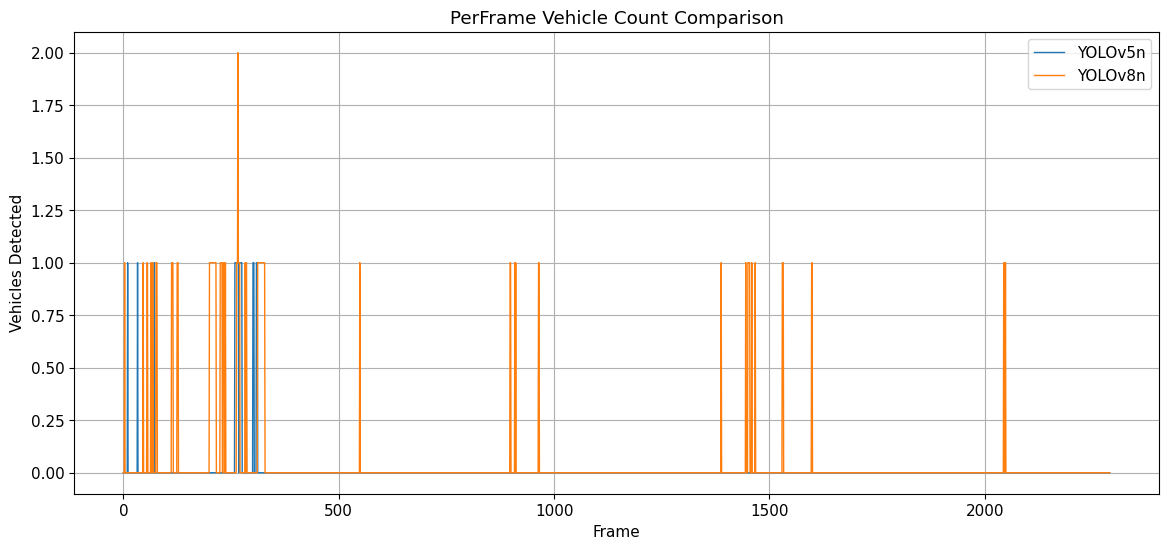

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(res_5n["per_frame"], label="YOLOv5n", linewidth=1)
plt.plot(res_8n["per_frame"], label="YOLOv8n", linewidth=1)
plt.title("PerFrame Vehicle Count Comparison")
plt.xlabel("Frame")
plt.ylabel("Vehicles Detected")
plt.grid(True)
plt.legend()
plt.show()


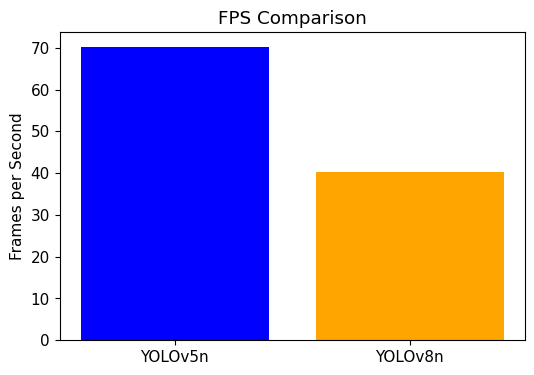

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(["YOLOv5n", "YOLOv8n"],
        [res_5n["fps"], res_8n["fps"]],
        color=["blue","orange"])
plt.title("FPS Comparison")
plt.ylabel("Frames per Second")
plt.show()


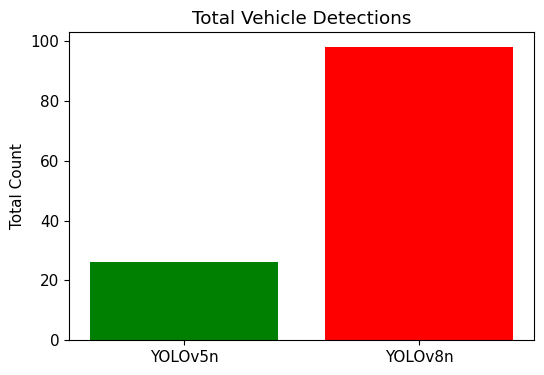

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(["YOLOv5n", "YOLOv8n"],
        [res_5n["total"], res_8n["total"]],
        color=["green","red"])
plt.title("Total Vehicle Detections")
plt.ylabel("Total Count")
plt.show()


Processing Time Summary
YOLOv5n Total Time: 32.63 seconds
YOLOv8n Total Time: 56.87 seconds

YOLOv5n Avg Time per Frame: 0.0142 s
YOLOv8n Avg Time per Frame: 0.0248 s


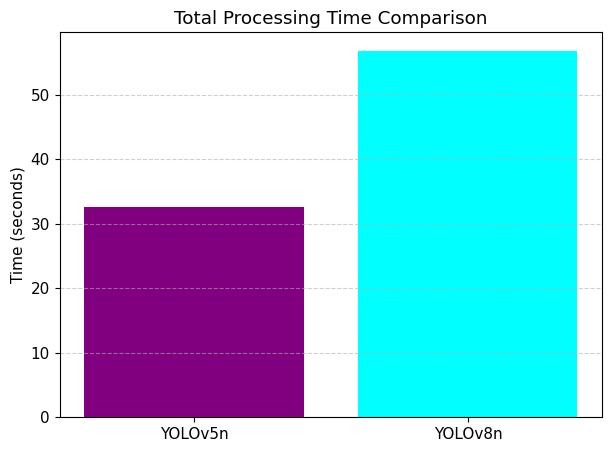

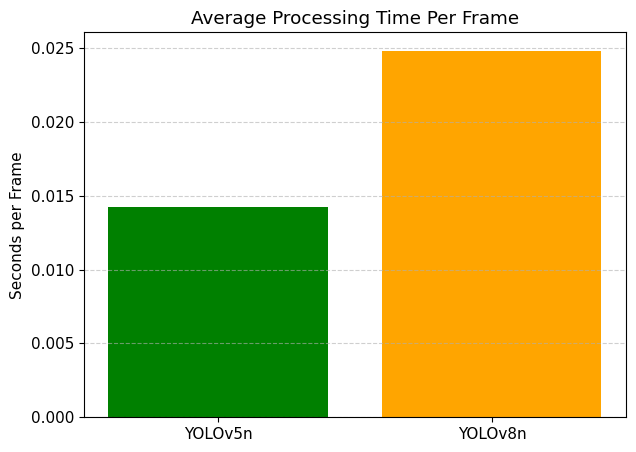

In [ ]:

# Extract processing times
time_5n = res_5n["processing_time"]
time_8n = res_8n["processing_time"]

# Compute average time per processed frame
avg_5n = time_5n / res_5n["frames"]
avg_8n = time_8n / res_8n["frames"]

print("Processing Time Summary")
print(f"YOLOv5n Total Time: {time_5n:.2f} seconds")
print(f"YOLOv8n Total Time: {time_8n:.2f} seconds")
print()
print(f"YOLOv5n Avg Time per Frame: {avg_5n:.4f} s")
print(f"YOLOv8n Avg Time per Frame: {avg_8n:.4f} s")

# Bar chart of processing times
plt.figure(figsize=(7,5))
plt.bar(["YOLOv5n", "YOLOv8n"],
        [time_5n, time_8n],
        color=["purple", "cyan"])

plt.title("Total Processing Time Comparison")
plt.ylabel("Time (seconds)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# Bar chart of average time per frame
plt.figure(figsize=(7,5))
plt.bar(["YOLOv5n", "YOLOv8n"],
        [avg_5n, avg_8n],
        color=["green", "orange"])

plt.title("Average Processing Time Per Frame")
plt.ylabel("Seconds per Frame")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()
